## **Aplicação de Random Forest Regression**
Neste notebook será aplicado o modelo Random Forest Regression utilizando as features extraídas dos dados .
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos benchmark **SARIMA**, **ETS** e **Regressão Linear**. 

In [1]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
import swifter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from feature_engine.creation import CyclicalFeatures 
from src.features import add_calendar_features
from src.features import add_lagged_features
from src.evaluation import Evaluation
from src.plots import plot_metrics, plot_time_series

# configurando notebook
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# configuração de estilo
sns.set_theme(context='paper')
plt.rcParams["figure.dpi"] = 150

%load_ext autoreload
%autoreload 2

EVAL_PATH = 'data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [2]:
# leitura dos dados
train_df = pd.read_csv("data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("data/test_df.csv", parse_dates=['ds'])

In [3]:
features_train_df = (
    train_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)


features_test_df = (
    test_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)

In [4]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter'],
      dtype='object')

In [5]:
# inserindo os lags nos dados de treino e teste

kwargs = {
    'features' : ['feriado', 'month_end'],
    'lags' : [-3, -2, -1, 1, 2, 3]
}

features_train_df = (
    features_train_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

features_test_df = (
    features_test_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

In [6]:
features_to_encode = [
    "day",
    "week",
    "day_of_week",
    "month",
    "quarter",
]
max_values = {
    "day" : 31,
    "week" : 53,
    "day_of_week" : 6,
    "month" : 12,
    "quarter" : 4,
}
cyclical_encoder = CyclicalFeatures(
    variables     = features_to_encode,
    max_values    = max_values,
    drop_original = False
)

features_train_df = cyclical_encoder.fit_transform(features_train_df)
features_test_df = cyclical_encoder.fit_transform(features_test_df)


In [7]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'feriado_lag-3', 'feriado_lag-2',
       'feriado_lag-1', 'feriado_lag1', 'feriado_lag2', 'feriado_lag3',
       'month_end_lag-3', 'month_end_lag-2', 'month_end_lag-1',
       'month_end_lag1', 'month_end_lag2', 'month_end_lag3', 'day_sin',
       'day_cos', 'week_sin', 'week_cos', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'quarter_sin', 'quarter_cos'],
      dtype='object')

## **Random Forest Regression**

In [8]:
def random_forest(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo RandomForest.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = features_test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train['trend'] = train.index
    fcst_df['trend'] = fcst_df.index + train.index.max() + 1
    
    m = RandomForestRegressor(
        n_estimators=1000, 
        max_depth=10, 
        min_samples_split=4, 
        random_state=1001
    )
    
    m.fit(
        X=train.iloc[:,3:], 
        y=train.y
    )
    
    fcst_df['y_pred'] = m.predict(X=fcst_df.iloc[:,3:])

    return fcst_df

In [9]:
# aplicando modelo para cada série
rf_fcst = (
    features_train_df
        .swifter
        .groupby("unique_id")
        .apply(random_forest)
        .reset_index(drop=True)
)

  0%|          | 0/15 [00:00<?, ?it/s]

2025-01-15 16:51:22,405	INFO worker.py:1821 -- Started a local Ray instance.


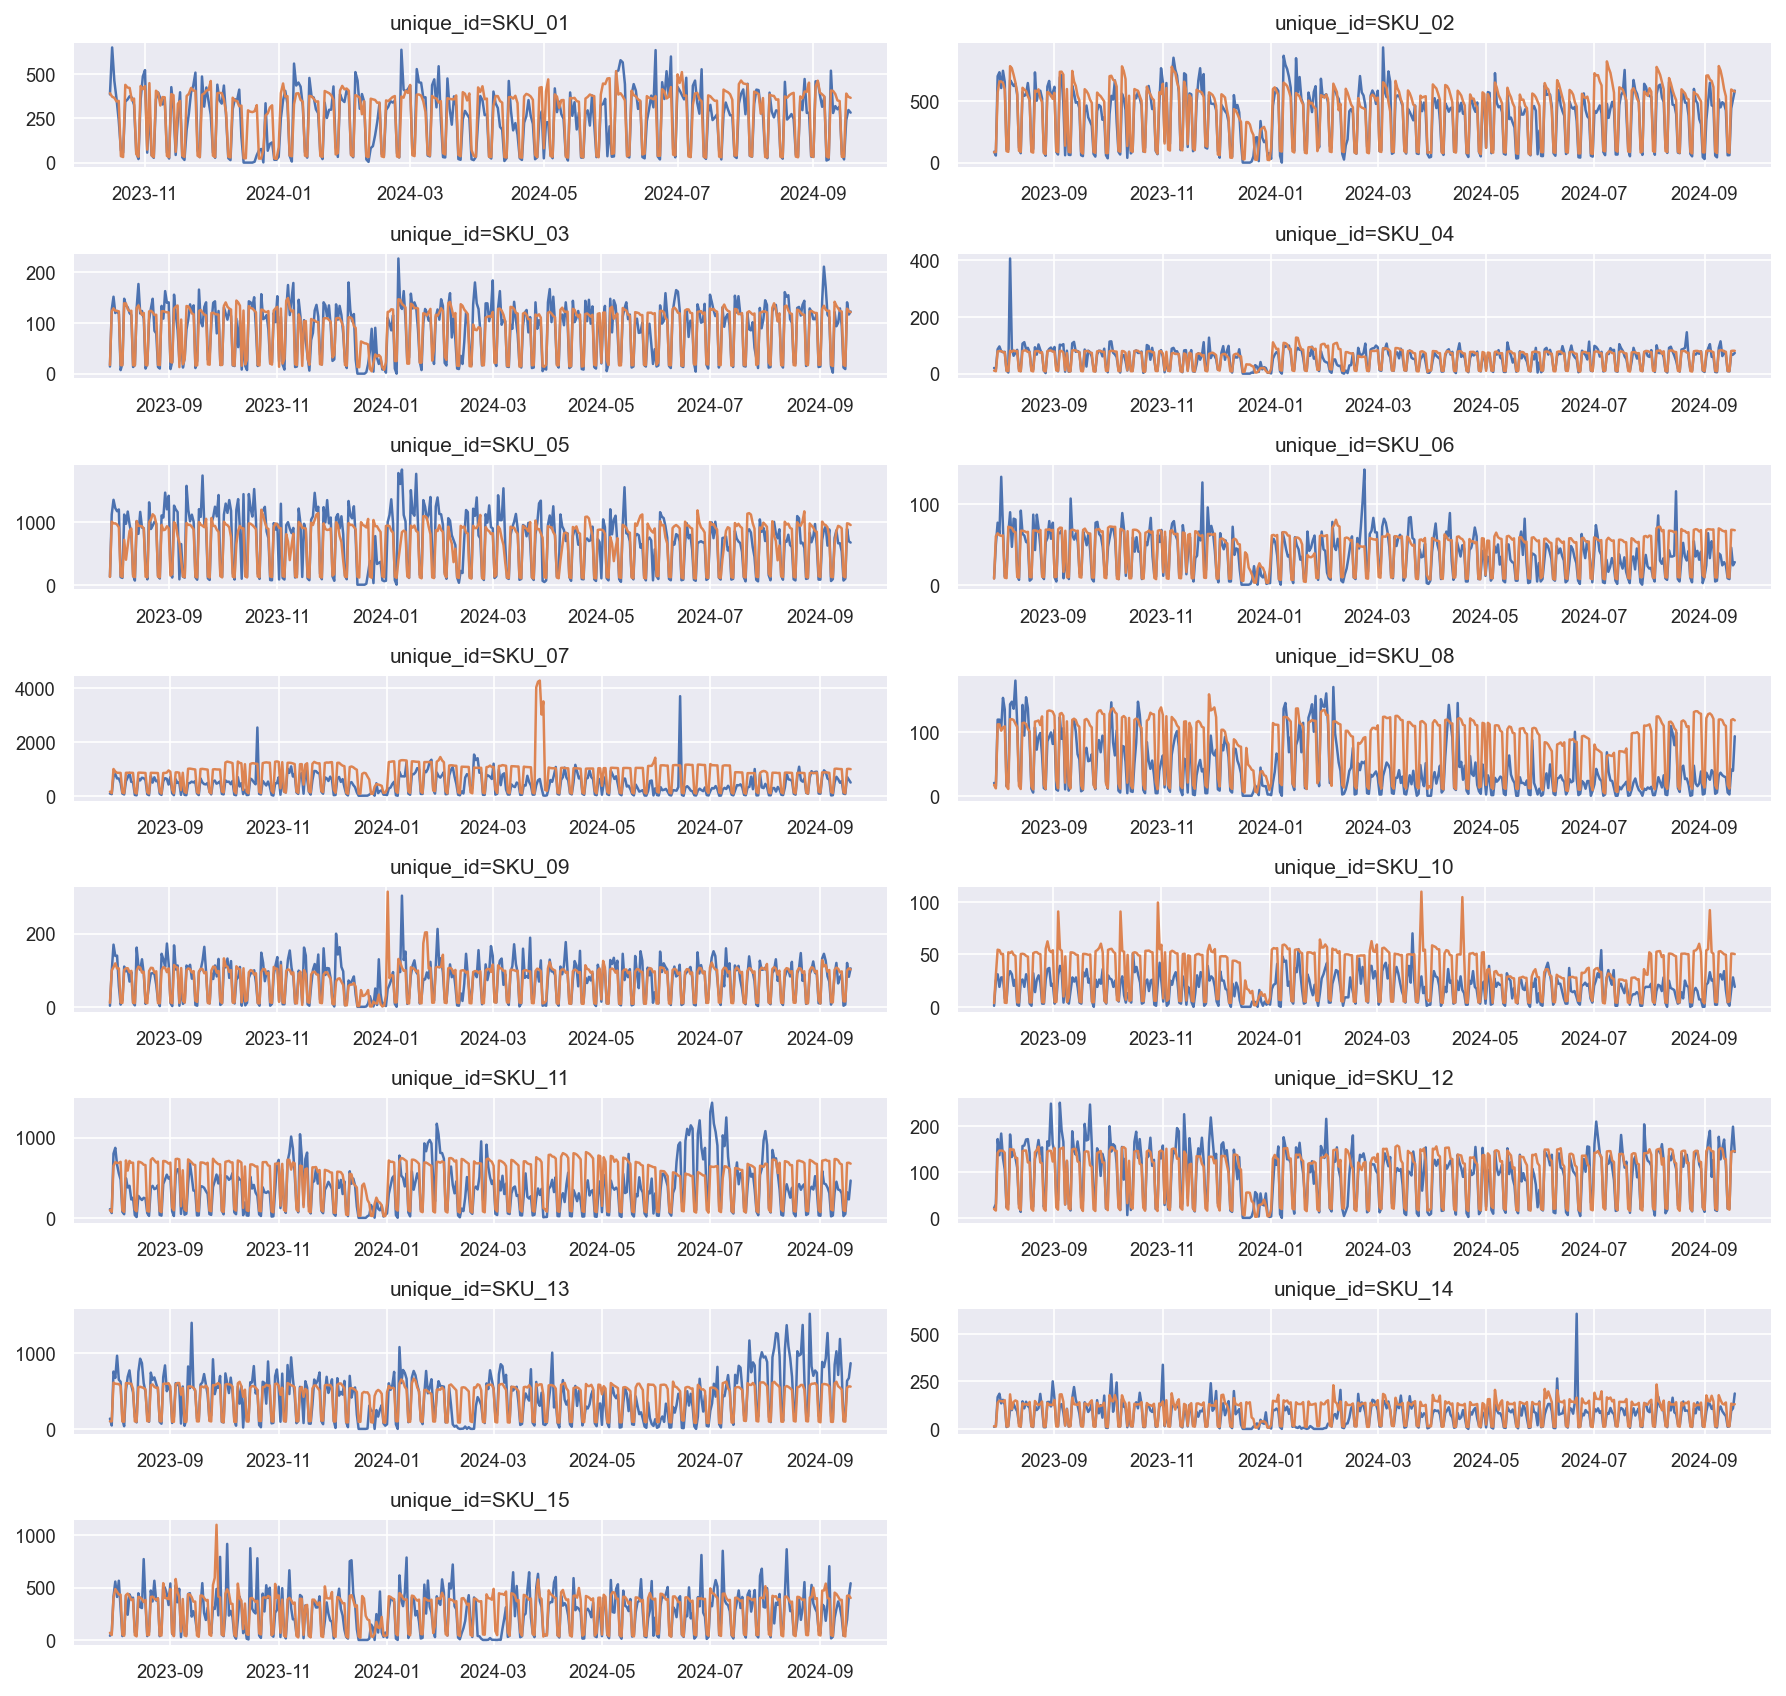

In [10]:
fig = plot_time_series(df=rf_fcst, data_cols=['y', 'y_pred'])

In [11]:
rf_eval = Evaluation(rf_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'Random Forest [+Lags +Fourier]')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,68.73,9546.87,97.71,0.66
SKU_02,82.77,13587.86,116.57,0.74
SKU_03,17.86,645.59,25.41,0.77
SKU_04,13.66,610.56,24.71,0.58
SKU_05,209.87,94428.01,307.29,0.56
SKU_06,14.00,366.61,19.15,0.48
SKU_07,415.21,382157.46,618.19,-1.67
SKU_08,40.87,2711.46,52.07,-0.61
SKU_09,19.77,1051.33,32.42,0.60
SKU_10,17.07,495.71,22.26,-2.10


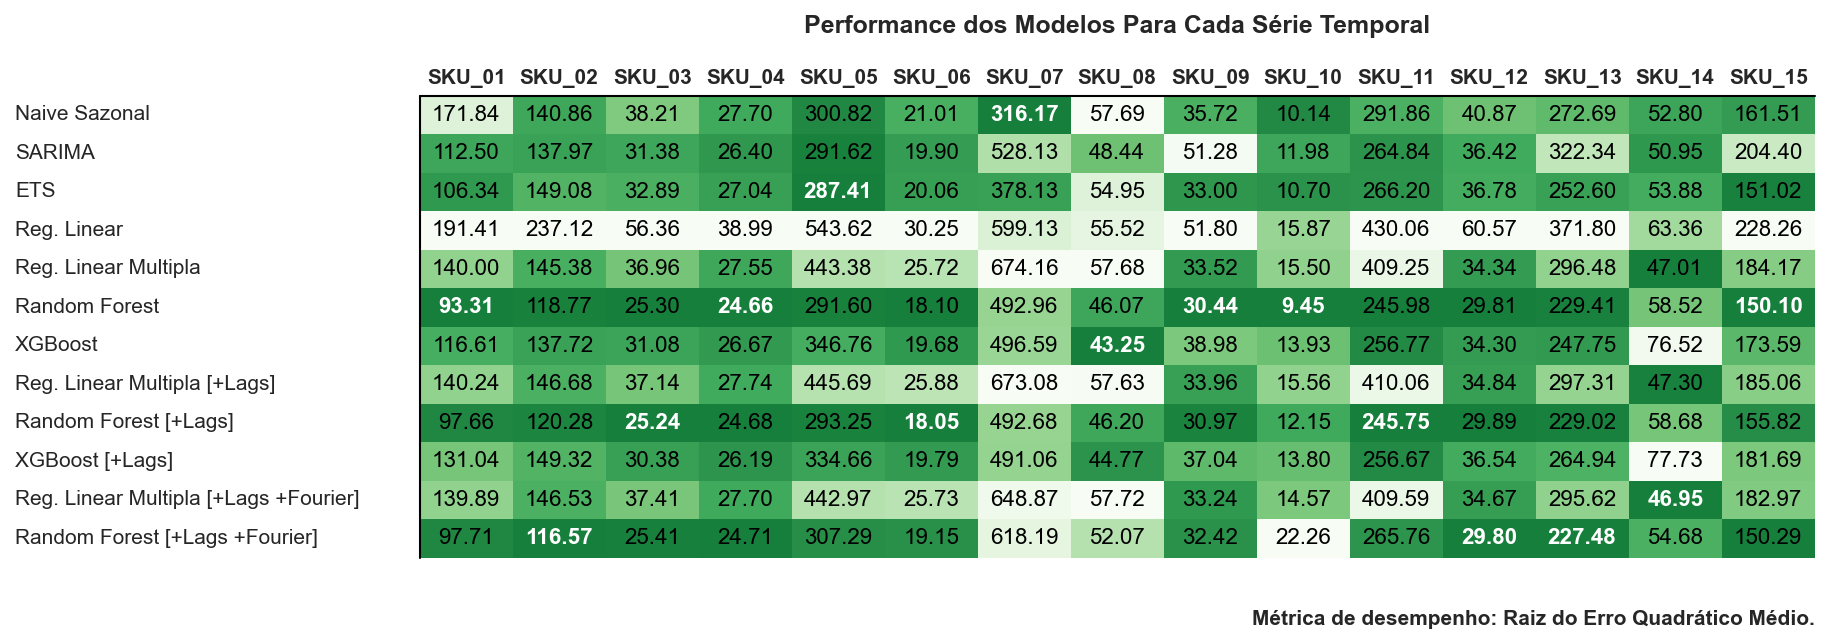

In [12]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].unique()
metrics = metrics.pivot_table('rmse','unique_id','model')[order]

fig = plot_metrics(metrics, figsize=(12, 4))